# Imports

In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figuresd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from skimage.feature import local_binary_pattern
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scipy.ndimage

# Download and organize the dataset (No Code required here)

In [2]:
from sklearn.datasets import fetch_openml
X_df, y_df = fetch_openml('mnist_784',version=1,cache=True,return_X_y=True)
X = X_df.values
y = y_df.values.astype(np.uint8)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


# Define a function that takes a list of images then samples 16 iamges from the list, then draws them using matplotlib in a 4x4 grid

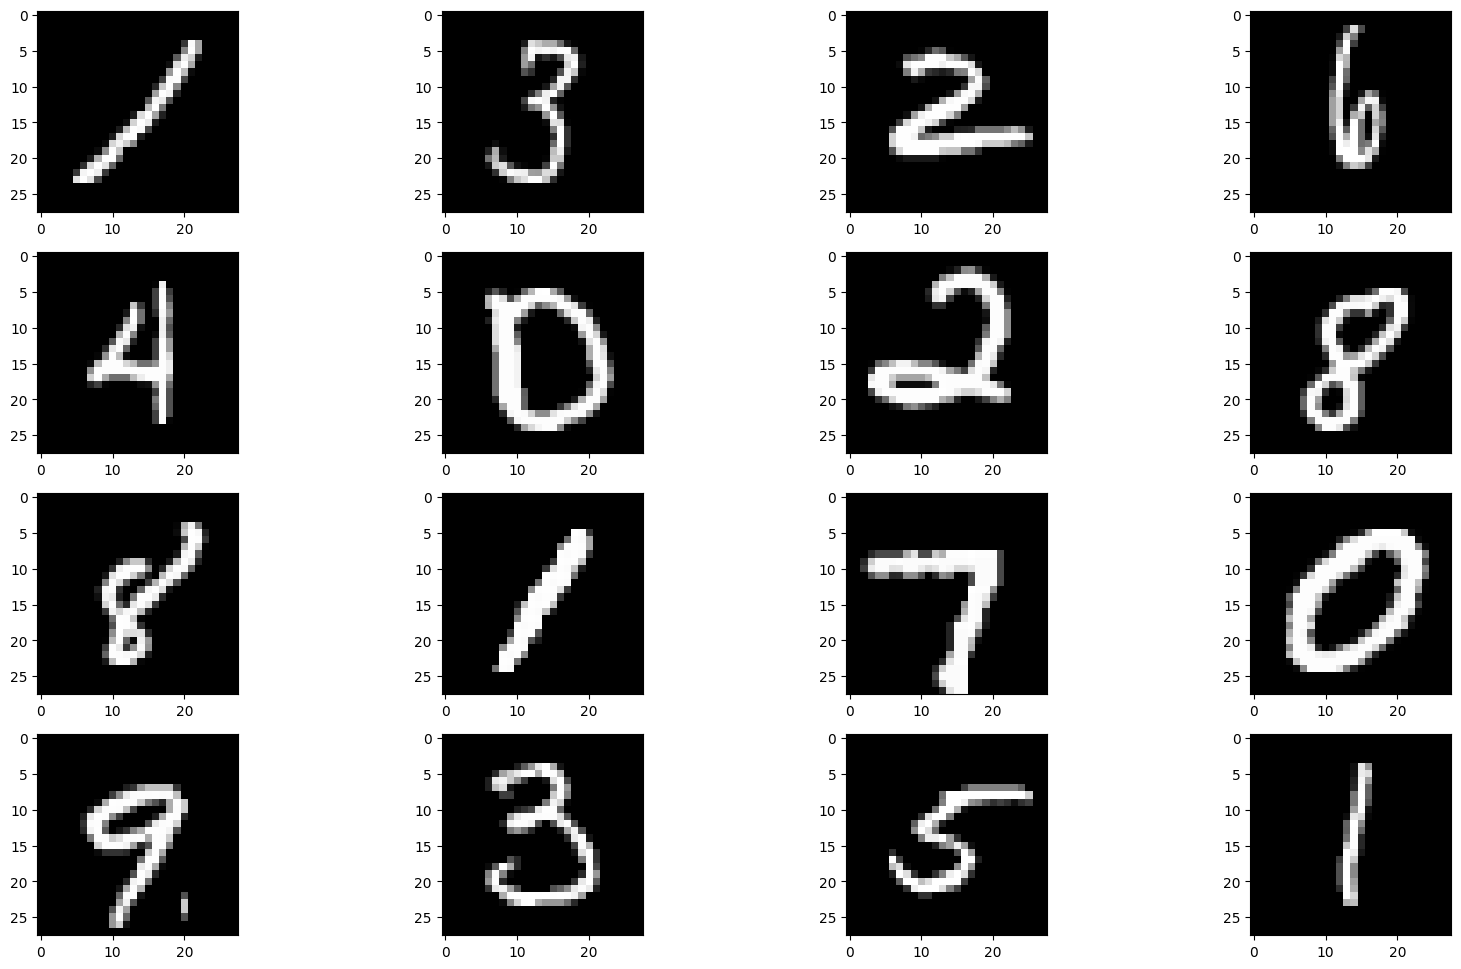

In [3]:
import random # u may need this library
random.seed(100) # set a seed in case you want your experiments to be consistent


def draw_func(Array_of_imgs):
  fig, axs = plt.subplots(4, 4,figsize=(20, 12))

  for ax in axs.flatten():
    img_sample = Array_of_imgs[random.randint(0,Array_of_imgs.shape[0]-1), :]
    img_sample = img_sample.reshape(28,28)
    ax.imshow(img_sample, cmap=plt.cm.gray)

  plt.show()

## Test your function using the read images here
draw_func(X)
##


# Count number of white pixels

In [4]:
Feature_num_white = [np.sum(img>128)/784 for img in X]
Feature_num_white = np.array(Feature_num_white)
print(Feature_num_white.mean(), Feature_num_white.std(), Feature_num_white.min(), Feature_num_white.max())

0.1309325437317784 0.04363825027341309 0.01913265306122449 0.3979591836734694


In [5]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming 'y' is a categorical variable
# for category in y.unique():
#     sns.kdeplot(Feature_num_white[y == category], label=f'Category {category}')

# plt.legend()
# plt.show()


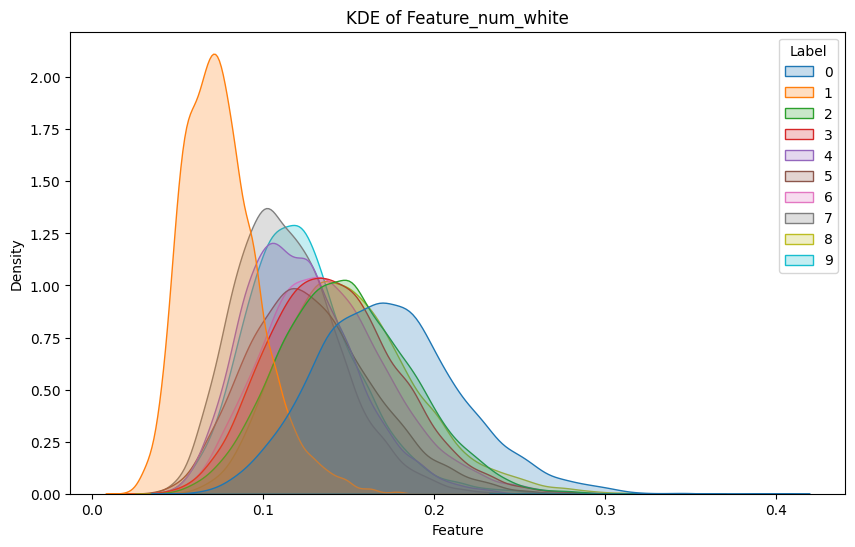

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert data to DataFrame
df = pd.DataFrame({'Feature': Feature_num_white, 'Label': y})

# Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='Feature', hue='Label', palette=sns.color_palette(), fill=True)
plt.title("KDE of Feature_num_white")
plt.show()


# Apply Gaussian derivative over the images

<ipython-input-7-3a33cd39880d>:6: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  gaussF = scipy.ndimage.filters.gaussian_filter(weights, 0.1, order=0,truncate=3.0)


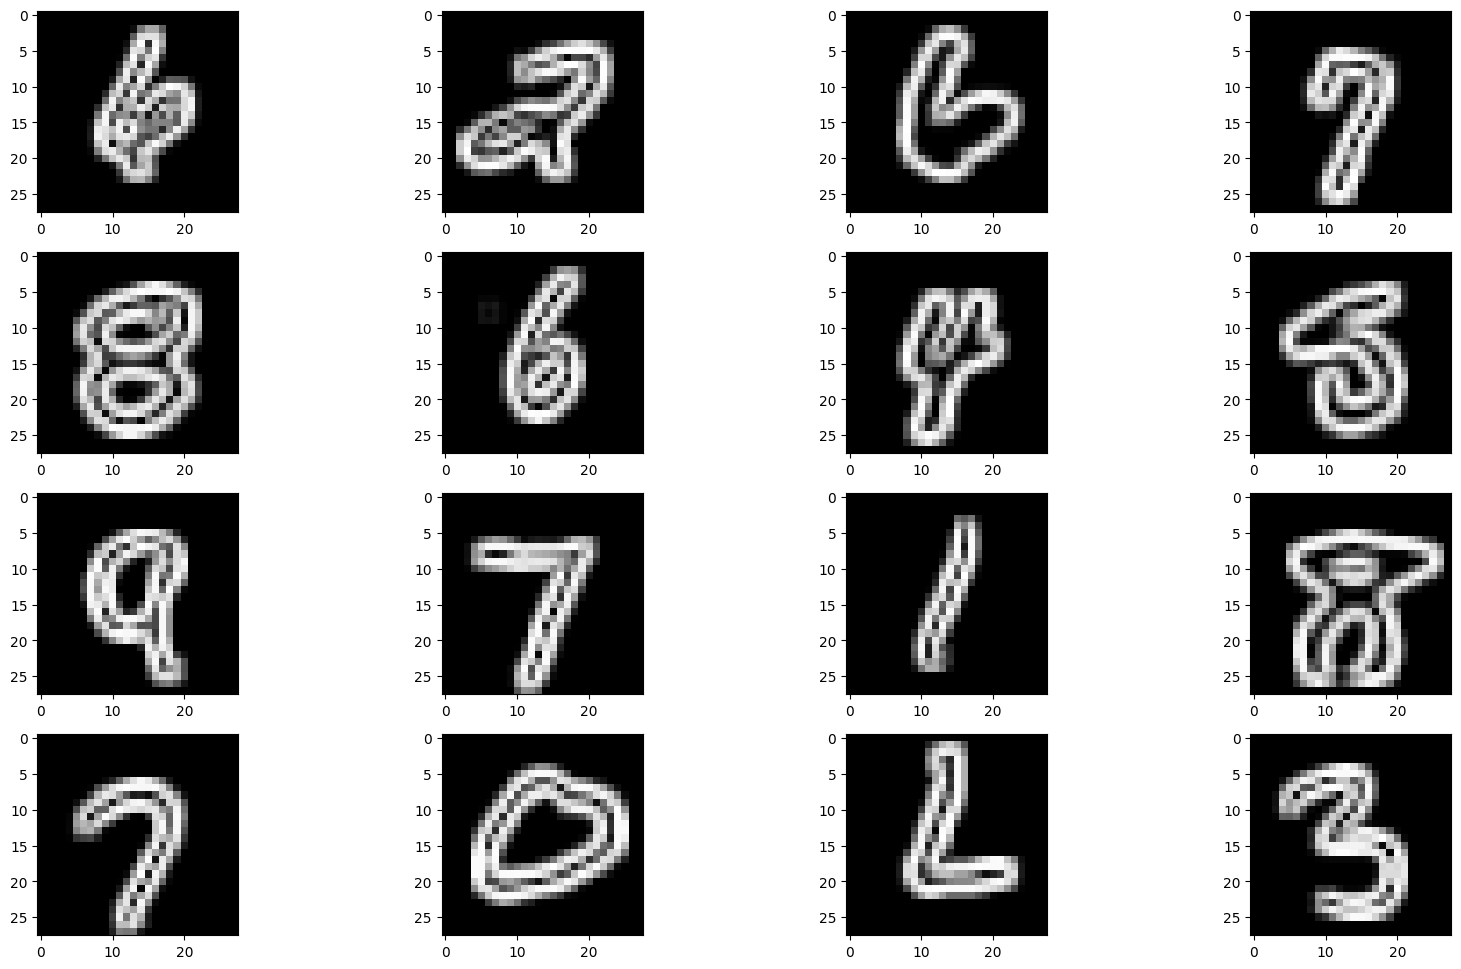

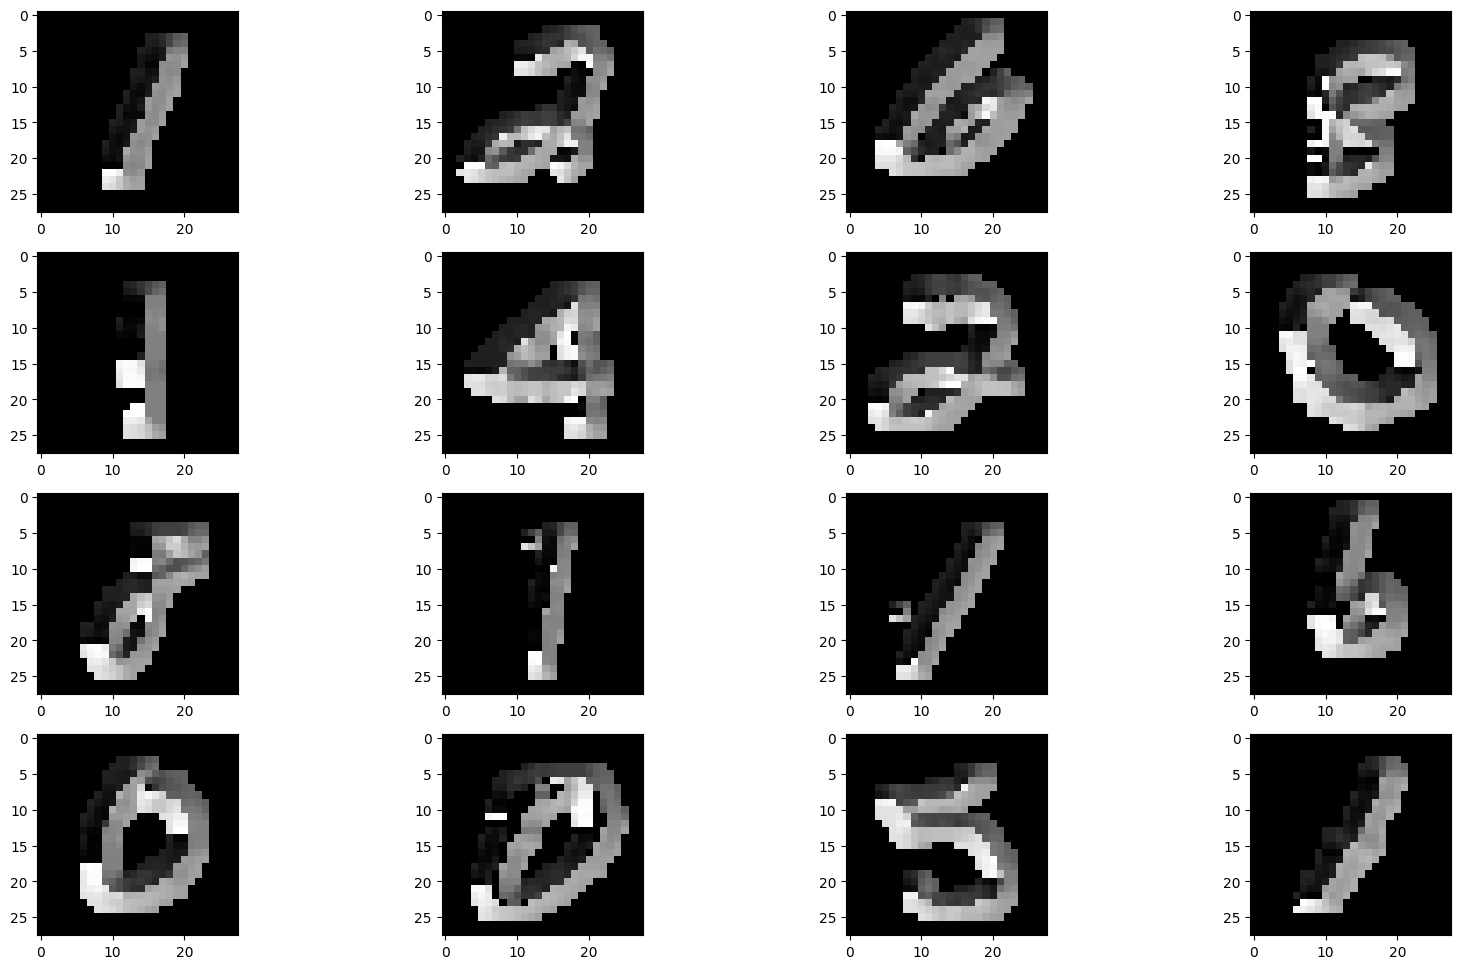

In [7]:
import scipy.ndimage
import math

weights = np.zeros((9, 9))
weights[4,4] = 1.0
gaussF = scipy.ndimage.filters.gaussian_filter(weights, 0.1, order=0,truncate=3.0)

#Sobel mask in x
weights = np.zeros((3,3))
weights[:,0] = -np.ones((3,))
weights[:,2] = np.ones((3,))
DoGx = scipy.ndimage.convolve(gaussF, weights)

#Sobel mask in y
weights = np.zeros((3,3))
weights[0,:] = np.ones((3,))
weights[2,:] = -np.ones((3,))
DoGy = scipy.ndimage.convolve(gaussF, weights)

devX = [scipy.ndimage.convolve(img, DoGx) for img in X.reshape(-1,28,28)] # Derivative in the X direction
devY = [scipy.ndimage.convolve(img, DoGy) for img in X.reshape(-1,28,28)] # Derivative in the Y direction

mag_imgs   = np.array([np.sqrt(np.square(devx) + np.square(devy)) for devx, devy in zip(devX, devY)])
angle_imgs = np.array([np.arctan2(-devy,devx) + math.pi           for devx, devy in zip(devX, devY)])

for angle, mag in zip(angle_imgs, mag_imgs):
  non_edge_indices = mag<0.5 # include only the edges with high gradients
  angle[non_edge_indices] = 0

# Use your draw function to visualize the magnitude
draw_func(mag_imgs)

# Use your draw function to visualize the orientation
draw_func(angle_imgs)

# Histogram of edges

In [8]:
actual_angles = []
for angle, mag in zip(angle_imgs, mag_imgs):
  mag_flat = mag.flatten()
  angle_flat = angle.flatten()

  indices = np.where(mag_flat>=0.5)[0]
  actual_angles_for_image = angle_flat[indices]/(2*math.pi)
  actual_angles.append(actual_angles_for_image)

bins = np.array(range(19))/18
Feature_edges_hist = [np.histogram(angle, bins=bins)[0] for angle in actual_angles]
Feature_edges_hist = np.array(Feature_edges_hist)

In [9]:
Feature_edges_hist

array([[ 3,  3, 31, ..., 27, 13,  5],
       [27, 16, 49, ...,  8,  5,  9],
       [34, 14, 16, ...,  7,  7,  6],
       ...,
       [16, 39, 30, ..., 12,  6,  7],
       [11, 14, 18, ..., 15,  6,  6],
       [14, 20, 51, ..., 22,  7,  5]])

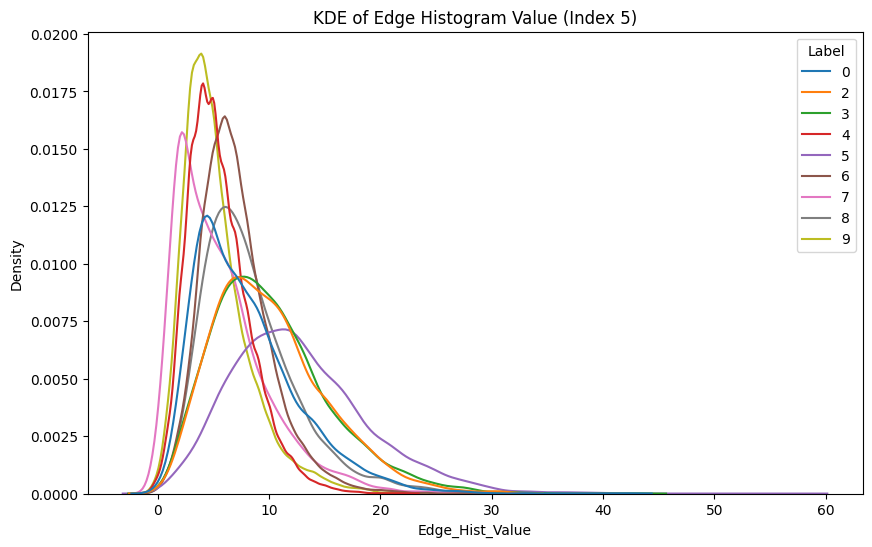

In [11]:
import pandas as pd

# Convert data to DataFrame
df = pd.DataFrame({
    'Edge_Hist_Value': [edge[5] for edge in Feature_edges_hist[y != 1]],
    'Label': y[y != 1]
})

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='Edge_Hist_Value', hue='Label', palette=sns.color_palette(n_colors=9))
plt.title("KDE of Edge Histogram Value (Index 5)")
plt.show()


# Your Turn

*   Apply model before feature extraction.
*   Apply model after feature extraction.
*   Try to enchance accuracy using at least 2 more features

Research:

*   Harris corner detector
*   SIFT



### Apply model before feature extraction

In [ ]:
# Split the data for raw images
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression on raw images
clf_raw = LogisticRegression(max_iter=5000, random_state=42)
clf_raw.fit(X_train, y_train)

# Predict on the test set
y_pred_raw = clf_raw.predict(X_test)

# Evaluate its performance
accuracy_raw = accuracy_score(y_test, y_pred_raw)

### Extract features

In [ ]:
# Feature: Number of white pixels
Feature_white = [np.sum(img>128)/784 for img in X]

# Feature: Mean pixel value
Feature_mean_pixel = np.mean(X, axis=1)

# Edge pixel count (assuming mag_imgs has already been computed)
Feature_edge_count = [np.sum(mag > 0.5) for mag in mag_imgs]


In [ ]:
# Combine features
X_features = np.column_stack((Feature_white, Feature_edges_hist, Feature_mean_pixel, Feature_edge_count))

### Apply model after feature extraction

In [ ]:
# Split the dataset for the features
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

In [ ]:
# Train logistic regression on combined features
clf_feat = LogisticRegression(max_iter=5000, random_state=42)
clf_feat.fit(X_train, y_train)

# Predict on the test set with features
y_pred_feat = clf_feat.predict(X_test)

# Evaluate its performance


In [ ]:
accuracy_feat = accuracy_score(y_test, y_pred_feat)
print(f"Accuracy on raw images: {accuracy_raw}")
print(f"Accuracy on extracted features: {accuracy_feat}")

### Try to enchance accuracy using at least 2 more features

In [ ]:
from scipy.stats import entropy

# 1. Compute the Entropy of the Image
def compute_image_entropy(img):
    hist = np.histogram(img, bins=256, range=(0, 256), density=True)[0]
    return entropy(hist)

Feature_entropy = [compute_image_entropy(img) for img in X]

# 2. Compute the Center of Mass of the Image
def compute_center_of_mass(img):
    row_cm = np.sum(np.arange(28) * img.sum(axis=1)) / img.sum()
    col_cm = np.sum(np.arange(28) * img.sum(axis=0)) / img.sum()
    return row_cm, col_cm

Feature_row_cm, Feature_col_cm = zip(*[compute_center_of_mass(img.reshape(28, 28)) for img in X])

# Combine all features
X_all_features = np.column_stack((Feature_num_white, Feature_edges_hist, Feature_entropy, Feature_row_cm, Feature_col_cm))

# Split the dataset for the enhanced features
X_train_all, X_test_all, y_train, y_test = train_test_split(X_all_features, y, test_size=0.2, random_state=42)

# Train logistic regression on enhanced features
clf_all_features = LogisticRegression(max_iter=1000, random_state=42)
clf_all_features.fit(X_train_all, y_train)

# Predict on the test set with enhanced features
y_pred_all = clf_all_features.predict(X_test_all)

# Evaluate its performance
accuracy_all_features = accuracy_score(y_test, y_pred_all)

print(f"Accuracy on raw images: {accuracy_raw}")
print(f"Accuracy on initially extracted features: {accuracy_feat}")
print(f"Accuracy on all features: {accuracy_all_features}")


In [ ]:
from skimage.feature import local_binary_pattern

# 1. Feature Engineering using Local Binary Patterns (LBP)

def extract_lbp(image, P=8, R=1):
    lbp = local_binary_pattern(image, P=P, R=R, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # Normalize
    return hist

# Apply LBP on the MNIST images and extract features
Feature_lbp = np.array([extract_lbp(img.reshape(28, 28)) for img in X])

# Combine LBP with previously extracted features
X_all_features_lbp = np.column_stack((X_all_features, Feature_lbp))

X_all_features_lbp.shape


In [ ]:
def extract_lbp(image, P=8, R=1):
    lbp = local_binary_pattern(image, P=P, R=R, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # Normalize
    return hist

In [ ]:
Feature_lbp = np.array([extract_lbp(img.reshape(28, 28)) for img in X])

In [ ]:
# Combine all features
X_all_features_combined = np.column_stack((X_all_features, Feature_lbp))

# Use RandomForest to determine feature importance
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_all_features_combined, y)

# Select important features
sfm = SelectFromModel(forest, threshold=0.005)
sfm.fit(X_all_features_combined, y)
X_important_features = sfm.transform(X_all_features_combined)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_important_features, y, test_size=0.2, random_state=42)

clf_important = RandomForestClassifier(n_estimators=100, random_state=42)
clf_important.fit(X_train_important, y_train)

In [ ]:
# Evaluate its performance
y_pred_important = clf_important.predict(X_test_important)
accuracy_important = accuracy_score(y_test, y_pred_important)

print(f"Accuracy on raw images: {accuracy_raw}")
print(f"Accuracy on initially extracted features: {accuracy_feat}")
print(f"Accuracy on all features: {accuracy_all_features}")
print(f"Accuracy with important features: {accuracy_important}")

In [ ]:
# 4. Combine Raw and Extracted Features

X_combined = np.column_stack((X, X_important_features))

# Train the model on the combined dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

clf_combined = RandomForestClassifier(n_estimators=100, random_state=42)
clf_combined.fit(X_train, y_train)

# Evaluate its performance
y_pred = clf_combined.predict(X_test)
accuracy_combined = accuracy_score(y_test, y_pred)

print(f"Accuracy using combined (raw + important features): {accuracy_combined}")

### Research:

*   **Harris corner detector:** This is an edge detection operator that detects corners. It works by detecting large variations in all directions. In the context of MNIST, it could be used to detect unique features in numbers, such as the intersection of two lines in the number "4".


---



*   **SIFT**: It's an algorithm to detect and describe local features in images. The keypoints and descriptors extracted using SIFT can be used to match different views of an object or scene. For MNIST, SIFT could potentially be used to extract distinctive keypoints for each number, which can then be used as features for classification.




